# Residual Networks

Welcome to the second assignment of this week! You will learn how to build very deep convolutional networks, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously practically feasible.

**In this assignment, you will:**
- Implement the basic building blocks of ResNets. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

This assignment will be done in Keras. 

Before jumping into the problem, let's run the cell below to load the required packages.

In [4]:
import numpy as np
import tensorflow as tf
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [5]:
tf.test.is_built_with_cuda()

False

In [3]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2,kernel_size=(f,f),strides =(1,1),padding='same',name = conv_name_base+'2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis =3,name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3,kernel_size=(1,1),strides =(1,1),padding='same',name = conv_name_base+'2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis =3,name=bn_name_base+'2c')(X)


    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [4]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2,kernel_size=(f,f),strides =(1,1),padding='same',name = conv_name_base+'2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis =3,name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3,kernel_size=(1,1),strides =(1,1),padding='same',name = conv_name_base+'2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis =3,name=bn_name_base+'2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3,kernel_size=(1,1),strides=(s,s),padding='valid',name=conv_name_base+'l',kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+'l')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X =Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [5]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X,f=3,filters= [128,128,512],stage=3,block='a',s=2)
    X = identity_block(X,3,[128,128,512],stage=3,block='b')
    X = identity_block(X,3,[128,128,512],stage=3,block='c')
    X = identity_block(X,3,[128,128,512],stage=3,block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X,f=3,filters=[256,256,1024],stage=4,block='a',s=2)
    X = identity_block(X,3,[256,256,1024],stage =4,block='b')
    X = identity_block(X,3,[256,256,1024],stage =4,block='c')
    X = identity_block(X,3,[256,256,1024],stage =4,block='d')
    X = identity_block(X,3,[256,256,1024],stage =4,block='e')
    X = identity_block(X,3,[256,256,1024],stage =4,block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
    X = identity_block(X,3,[512,512,2048],stage =5,block='b')
    X = identity_block(X,3,[512,512,2048],stage =5,block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2),padding='valid',name ='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Run the following code to build the model's graph. If your implementation is not correct you will know it by checking your accuracy when running `model.fit(...)` below.

In [8]:
input_shape = (224, 224, 3)

model = ResNet50(input_shape =input_shape, classes = 1000)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

As seen in the Keras Tutorial Notebook, prior training a model, you need to configure the learning process by compiling the model.

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model is now ready to be trained. The only thing you need is a dataset.

In [31]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Run the following cell to train your model on 2 epochs with a batch size of 32. On a CPU it should take you around 5min per epoch. 

In [32]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 206s 191ms/step - loss: 3.2572 - acc: 0.2639
Epoch 2/2
1080/1080 [==============================] - 196s 182ms/step - loss: 2.4568 - acc: 0.3028


**Expected Output**:

<table>
    <tr>
        <td>
            ** Epoch 1/2**
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.2 and 0.5, although your results can be different from ours.
        </td>
    </tr>
    <tr>
        <td>
            ** Epoch 2/2**
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.2 and 0.5, you should see your loss decreasing and the accuracy increasing.
        </td>
    </tr>

</table>

Let's see how this model (trained on only two epochs) performs on the test set.

In [33]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 4s 37ms/step
Loss = 13.243693606058757
Test Accuracy = 0.16666666716337203


**Expected Output**:

<table>
    <tr>
        <td>
            **Test Accuracy**
        </td>
        <td>
           between 0.16 and 0.25
        </td>
    </tr>

</table>

For the purpose of this assignment, we've asked you to train the model only for two epochs. You can see that it achieves poor performances. Please go ahead and submit your assignment; to check correctness, the online grader will run your code only for a small number of epochs as well.

After you have finished this official (graded) part of this assignment, you can also optionally train the ResNet for more iterations, if you want. We get a lot better performance when we train for ~20 epochs, but this will take more than an hour when training on a CPU. 

Using a GPU, we've trained our own ResNet50 model's weights on the SIGNS dataset. You can load and run our trained model on the test set in the cells below. It may take ≈1min to load the model.

In [34]:
model = load_model('ResNet50.h5') 

OSError: Unable to open file (unable to open file: name = 'ResNet50.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [35]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 4s 30ms/step
Loss = 13.243693606058757
Test Accuracy = 0.16666666716337203


ResNet50 is a powerful model for image classification when it is trained for an adequate number of iterations. We hope you can use what you've learnt and apply it to your own classification problem to perform state-of-the-art accuracy.

Congratulations on finishing this assignment! You've now implemented a state-of-the-art image classification system! 

## 4 - Test on your own image (Optional/Ungraded)

If you wish, you can also take a picture of your own hand and see the output of the model. To do this:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right! 

In [ ]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

You can also print a summary of your model by running the following code.

In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Finally, run the code below to visualize your ResNet50. You can also download a .png picture of your model by going to "File -> Open...-> model.png".

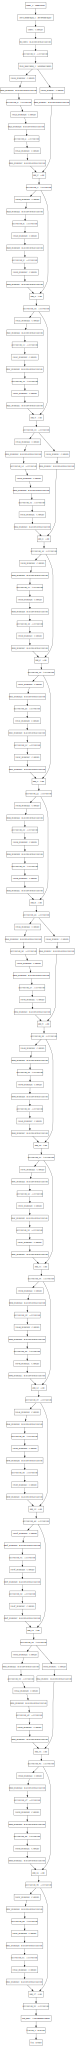

In [38]:
# 增加graphviz到环境变量
import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

<font color='blue'>
**What you should remember:**
- Very deep "plain" networks don't work in practice because they are hard to train due to vanishing gradients.  
- The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main type of blocks: The identity block and the convolutional block. 
- Very deep Residual Networks are built by stacking these blocks together.

### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the github repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's github repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
